In [115]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
from mlxtend.plotting import plot_decision_regions
import sklearn
from torch.nn.functional import one_hot
import torchvision
from torch.utils.data import Dataset,DataLoader
import os
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import Subset

In [108]:
class CelebADataset(Dataset):
    def __init__(self,image_path,transform = None,split="train"):
        try:
            self.image_dir_path = os.path.join(image_path,"img_align_celeba/img_align_celeba")
            assert os.path.exists(self.image_dir_path )
        
            self.partition_data = pd.read_csv(os.path.join(image_path,"list_eval_partition.csv"))

            ##extract Smiling attribute
            self.attrs = pd.read_csv(os.path.join(image_path,"list_attr_celeba.csv"))
            self.attrs = self.attrs[["image_id","Smiling"]]
            self.attrs = self.attrs.set_index("image_id")
            self.attrs.index.names = [None]
            
            if split == "train":
                self.image_list = self.__get_partition(partition_value=0)
            elif split == "valid":
                self.image_list = self.__get_partition(partition_value=1)
            elif split == "test":
                self.image_list = self.__get_partition(partition_value=2)
            else:
                raise ValueError("Incorrect partition type")

            self.images = [os.path.join(self.image_dir_path,f) for f in self.image_list]
            

        except AssertionError:
            print("invalid dataset. img_align_celeba folder not found")

        self.transform = transform

    def __get_partition(self,partition_value=0):
        return self.partition_data.where(self.partition_data["partition"]==partition_value)["image_id"].dropna().to_list()

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image_path = self.images[idx]
        image_name = os.path.basename(image_path)
        # print("Image name is :: {}".format(image_name))
        img = Image.open(image_path).convert("RGB")
        target = max(0,self.attrs.loc[image_name]["Smiling"])
        if self.transform:
            img = self.transform(img)
        return img,target

In [109]:
transforms_train = transforms.Compose([
    transforms.RandomCrop([178,178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64,64]),
    transforms.ToTensor(),
])

In [110]:
transform_valid_test = transforms.Compose([
    transforms.RandomCrop([178,178]),
    transforms.Resize([64,64]),
    transforms.ToTensor(),
])

In [111]:
image_path = "../data/celeba/"

In [112]:
celeba_train_dataset = CelebADataset(image_path,split="train",transform=transforms_train)
celeba_valid_dataset = CelebADataset(image_path,split="valid",transform=transforms_train)
celeba_test_dataset = CelebADataset(image_path,split="test",transform=transforms_train)

In [113]:
torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset,batch_size=2)


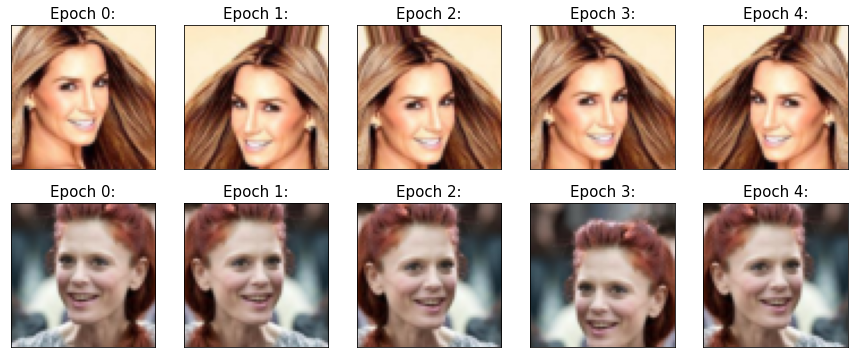

In [114]:
num_epochs = 5
fig = plt.figure(figsize=(15,6))
for j in range(num_epochs):
    img_batch, img_label = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2,5,j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:',size=15)
    ax.imshow(img.permute(1,2,0))

    img = img_batch[1]
    ax = fig.add_subplot(2,5,j+6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:',size=15)
    ax.imshow(img.permute(1,2,0))



In [116]:
celeba_train_dataset = Subset(celeba_train_dataset,torch.arange(16000))

In [117]:
celeba_valid_dataset = Subset(celeba_valid_dataset,torch.arange(1000))

In [118]:
print("Train set: ",len(celeba_train_dataset))

Train set:  16000


In [120]:
batch_size = 16
torch.manual_seed(1)

train_dl = DataLoader(celeba_train_dataset,batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset,batch_size=batch_size,shuffle=True)
test_dl = DataLoader(celeba_test_dataset,batch_size=batch_size,shuffle=True)

In [131]:
class SmileClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        conv_block1 = self.conv_block(3,32,3,1)
        conv_block2 = self.conv_block(32,64,3,1)
        conv_block3 = self.conv_block(64,128,3,1,dropout=False)
        conv_block4 = self.conv_block(128,256,3,1,dropout=False,pool_type="avg")

        l = conv_block1 + conv_block2 + conv_block3 + conv_block4
        self.module_list = nn.ModuleList(l)
        self.module_list.add_module('flatten',nn.Flatten())
        self.module_list.add_module('fc',nn.Linear(256,1))
        self.module_list.add_module('sigmoid',nn.Sigmoid())

    def conv_block(self,in_channels,out_channels,kernel_size,padding,dropout=True,pool_type="max"):
        conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,padding=padding) 
        relu = nn.ReLU()
        if  pool_type == "max":
            pool = nn.MaxPool2d(kernel_size=2)
        elif pool_type =="avg":
            pool = nn.AvgPool2d(kernel_size=8)
        if dropout:
            dropout_layer = nn.Dropout(p=0.5)
            return [conv,relu,pool,dropout_layer]
        else:
            return [conv,relu,pool]

    def forward(self,x):
        for f in self.module_list:
            x = f(x)
        return x



In [135]:
model = SmileClassifier()

In [136]:
x = torch.ones((4,3,64,64))
model(x).shape

torch.Size([4, 1])

In [137]:
model

SmileClassifier(
  (module_list): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=256, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [140]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

In [ ]:
def train(model, num_epochs=200, train_dl=None,x_valid=None,y_valid=None):
    loss_hist_train = [0]*num_epochs
    accuracy_hist_train = [0]*num_epochs
    loss_hist_valid = [0]*num_epochs
    accuracy_hist_valid = [0]*num_epochs
    print("Num of epochs are :: {}".format(num_epochs))
    print("Optimiser is :: {}".format(optimizer))
    for epoch in range(num_epochs):
        for x_batch,y_batch in train_dl:
            pred = model(x_batch)[:,0]
            loss = loss_fn(pred,y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            print("Is correct is :: {}".format(is_correct.mean()))
            accuracy_hist_train[epoch] += is_correct.mean()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch,y_batch in valid_dl:
                pred = model(x_batch)[:,0]
                loss = loss_fn(pred,y_batch.float())
                
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                print("Is correct is :: {}".format(is_correct.mean()))
                accuracy_hist_valid[epoch] += len(valid_dl.dataset)
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid